## Thickness Map ROI Definition

This notebook defines Region of Interest (ROI) on thickness maps using detection bounding boxes.

**Methods:**
1. **Thickened Lines**: Expand detection lines vertically
2. **Connected Polygons**: Create polygons around blobs of detections

**Key Features:**
- Separate ROIs for fovea (class 1) and SCR (class 2) detections
- For polygons: separate blobs instead of connecting all detections together

In [1]:
# Import required libraries
import h5py
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from collections import defaultdict
from scipy.ndimage import label as connected_components
import cv2

In [2]:
# Paths
data_path = '/home/suraj/Data/Nemours/Nemours_Jing_0929.h5'
detection_path = '/home/suraj/Git/RCNN-OCT/nemours_inference/full_dataset_inference.pkl'

In [3]:
# Load HDF5 annotations data
print("Loading HDF5 annotations data...")
with h5py.File(data_path, 'r') as f:
    images = f['images'][:]
    names = f['names'][:]
    bscan_indices = f['bscan_indices'][:]
    
    if isinstance(names[0], bytes):
        names = [name.decode('utf-8') for name in names]
    
    ilm_coords = f['layers/ILM'][:]
    bm_coords = f['layers/BM'][:]

print(f"Loaded {len(names)} B-scans")

Loading HDF5 annotations data...
Loaded 2540 B-scans


In [4]:
# Load inference detections
print("Loading inference detections...")
with open(detection_path, 'rb') as f:
    detection_data = pickle.load(f)

print(f"Loaded detections for {len(detection_data)} volumes")

Loading inference detections...
Loaded detections for 104 volumes


In [5]:
# Create mapping from HDF5 data
hdf5_mapping = {}
for idx, (name, bscan_idx) in enumerate(zip(names, bscan_indices)):
    vol_id = name.replace('.e2e', '')
    key = f"{vol_id}_{bscan_idx:03d}"
    hdf5_mapping[key] = {
        'global_idx': idx,
        'volume_id': vol_id,
        'bscan_idx': bscan_idx
    }

# Create mapping from detection data
detection_mapping = {}
for vol_id, bscans in detection_data.items():
    for bscan_data in bscans:
        bscan_idx = bscan_data['bscan_idx']
        key = f"{vol_id}_{bscan_idx:03d}"
        detection_mapping[key] = {
            'volume_id': vol_id,
            'bscan_idx': bscan_idx,
            'pred_boxes': bscan_data['pred_boxes'],
            'pred_labels': bscan_data['pred_labels'],
            'pred_scores': bscan_data['pred_scores']
        }

print(f"Created mappings for {len(hdf5_mapping)} entries")

Created mappings for 2540 entries


In [6]:
def compute_thickness(ilm, bm):
    """Compute retinal thickness as vertical distance between ILM and BM."""
    return bm - ilm


def create_volume_thickness_map(volume_id, score_threshold=0.5):
    """
    Create 2D thickness map for entire volume and extract bounding box information.
    
    Returns:
    --------
    thickness_map : np.ndarray
        2D array (num_bscans, width) of thickness values
    bb_info : list
        List of dicts with 'bscan_idx' and 'boxes' (list of box dicts)
    bscan_indices : list
        B-scan indices corresponding to rows in thickness_map
    """
    # Get available B-scans for this volume
    available_bscans = []
    for key in hdf5_mapping.keys():
        if hdf5_mapping[key]['volume_id'] == volume_id:
            available_bscans.append(hdf5_mapping[key]['bscan_idx'])
    
    if not available_bscans:
        print(f"Volume '{volume_id}' not found")
        return None, None, None
    
    available_bscans = sorted(available_bscans)
    
    thickness_list = []
    bb_info = []
    
    for bscan_idx in available_bscans:
        key = f"{volume_id}_{bscan_idx:03d}"
        
        # Get thickness
        global_idx = hdf5_mapping[key]['global_idx']
        ilm = ilm_coords[global_idx]
        bm = bm_coords[global_idx]
        thickness = compute_thickness(ilm, bm)
        thickness_list.append(thickness)
        
        # Get detections
        det_data = detection_mapping.get(key, {'pred_boxes': [], 'pred_labels': [], 'pred_scores': []})
        
        bscan_boxes = []
        for box, label, score in zip(det_data['pred_boxes'], det_data['pred_labels'], det_data['pred_scores']):
            if score >= score_threshold:
                x1, y1, x2, y2 = box
                bscan_boxes.append({
                    'x1': int(x1),
                    'x2': int(x2),
                    'label': int(label),
                    'score': float(score)
                })
        
        bb_info.append({
            'bscan_idx': bscan_idx,
            'boxes': bscan_boxes
        })
    
    thickness_map = np.array(thickness_list)
    return thickness_map, bb_info, available_bscans


print("Thickness computation functions created!")

Thickness computation functions created!


## ROI Definition Methods

In [7]:
def create_thickened_line_roi(thickness_map, bb_info, line_thickness=3, label_filter=None):
    """
    Method 1: Create ROI by thickening detection lines.
    
    Parameters:
    -----------
    thickness_map : np.ndarray
        Thickness map (num_bscans, width)
    bb_info : list
        Bounding box information
    line_thickness : int
        Number of pixels to expand vertically on each side
        Total thickness = 2*line_thickness + 1
    label_filter : int, optional
        If specified, only use boxes with this label (1=fovea, 2=SCR)
    
    Returns:
    --------
    roi_mask : np.ndarray
        Binary mask of ROI (same shape as thickness_map)
    """
    roi_mask = np.zeros_like(thickness_map, dtype=bool)
    
    for idx, bb_data in enumerate(bb_info):
        y_pos = idx  # Row position in thickness map
        
        for box in bb_data['boxes']:
            # Filter by label if specified
            if label_filter is not None and box['label'] != label_filter:
                continue
            
            x1 = box['x1']
            x2 = box['x2']
            
            # Define vertical extent (thicken the line)
            y_min = max(0, y_pos - line_thickness)
            y_max = min(roi_mask.shape[0], y_pos + line_thickness + 1)
            
            # Fill the thickened line
            roi_mask[y_min:y_max, x1:x2] = True
    
    return roi_mask


print("Method 1 (Thickened Lines) function created!")

Method 1 (Thickened Lines) function created!


In [8]:
def create_polygon_roi(thickness_map, bb_info, label_filter=None):
    """
    Method 2: Create ROI by drawing polygons around blobs of detections.
    
    This function:
    1. Creates a binary mask from detection lines
    2. Identifies connected components (blobs)
    3. Creates a convex hull polygon around each blob
    
    Parameters:
    -----------
    thickness_map : np.ndarray
        Thickness map (num_bscans, width)
    bb_info : list
        Bounding box information
    label_filter : int, optional
        If specified, only use boxes with this label (1=fovea, 2=SCR)
    
    Returns:
    --------
    roi_mask : np.ndarray
        Binary mask of ROI
    polygons : list
        List of polygon point arrays for visualization
    """
    # Step 1: Create initial binary mask from detection lines
    initial_mask = np.zeros_like(thickness_map, dtype=np.uint8)
    
    for idx, bb_data in enumerate(bb_info):
        y_pos = idx
        
        for box in bb_data['boxes']:
            if label_filter is not None and box['label'] != label_filter:
                continue
            
            x1 = box['x1']
            x2 = box['x2']
            initial_mask[y_pos, x1:x2] = 1
    
    # Step 2: Find connected components (blobs)
    labeled_mask, num_blobs = connected_components(initial_mask)
    
    # Step 3: Create polygon around each blob
    roi_mask = np.zeros_like(thickness_map, dtype=np.uint8)
    polygons = []
    
    for blob_id in range(1, num_blobs + 1):
        # Get points belonging to this blob
        blob_points = np.argwhere(labeled_mask == blob_id)
        
        if len(blob_points) < 3:
            # Need at least 3 points for a polygon
            continue
        
        # Convert to (x, y) format for cv2
        points = blob_points[:, [1, 0]]  # Swap to (x, y)
        
        # Create convex hull around the blob
        hull = cv2.convexHull(points.astype(np.float32))
        hull_points = hull.squeeze().astype(np.int32)
        
        # Fill polygon
        cv2.fillPoly(roi_mask, [hull_points], 1)
        polygons.append(hull_points)
    
    return roi_mask.astype(bool), polygons


print("Method 2 (Connected Polygons) function created!")

Method 2 (Connected Polygons) function created!


In [15]:
def plot_roi_methods(volume_id, score_threshold=0.7, line_thickness=3, figsize=(20, 15)):
    """
    Visualize both ROI methods with separate fovea and SCR regions.
    
    Layout:
    - Row 1: Original thickness map with detections
    - Row 2: Method 1 (Thickened Lines) - Fovea and SCR separate
    - Row 3: Method 2 (Polygons) - Fovea and SCR separate
    """
    # Create thickness map
    thickness_map, bb_info, bscan_indices = create_volume_thickness_map(volume_id, score_threshold)
    
    if thickness_map is None:
        return
    
    # Create ROIs for both classes using both methods
    # Method 1: Thickened Lines
    roi_fovea_lines = create_thickened_line_roi(thickness_map, bb_info, line_thickness, label_filter=1)
    roi_scr_lines = create_thickened_line_roi(thickness_map, bb_info, line_thickness, label_filter=2)
    
    # Method 2: Polygons
    roi_fovea_poly, polygons_fovea = create_polygon_roi(thickness_map, bb_info, label_filter=1)
    roi_scr_poly, polygons_scr = create_polygon_roi(thickness_map, bb_info, label_filter=2)
    
    # Create figure
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    
    # Row 1: Original thickness map with detections
    for col, (title, label_filter, color) in enumerate([
        ('Fovea Detections', 1, 'lime'),
        ('SCR Detections', 2, 'cyan')
    ]):
        ax = axes[0, col]
        im = ax.imshow(thickness_map, aspect='auto', cmap='hot', 
                      interpolation='bilinear', vmin=40, vmax=120)
        
        # Overlay detection lines
        for idx, bb_data in enumerate(bb_info):
            for box in bb_data['boxes']:
                if box['label'] == label_filter:
                    ax.plot([box['x1'], box['x2']], [idx, idx], 
                           color=color, linewidth=2, alpha=0.8)
                    # Mark center
                    center_x = (box['x1'] + box['x2']) / 2
                    ax.plot(center_x, idx, 'x', color=color, 
                           markersize=8, markeredgewidth=2)
        
        ax.set_title(f'Original: {title}', fontweight='bold', fontsize=12)
        ax.set_xlabel('A-scan Index')
        ax.set_ylabel('B-scan Index')
        
        if col == 1:
            plt.colorbar(im, ax=ax, label='Thickness (pixels)')
    
    # Row 2: Method 1 - Thickened Lines
    for col, (roi_mask, title, color) in enumerate([
        (roi_fovea_lines, f'Fovea (thickness={line_thickness})', 'Greens'),
        (roi_scr_lines, f'SCR (thickness={line_thickness})', 'Blues')
    ]):
        ax = axes[1, col]
        ax.imshow(thickness_map, aspect='auto', cmap='hot', 
                 interpolation='bilinear', vmin=40, vmax=120)
        ax.imshow(roi_mask, aspect='auto', cmap=color, alpha=0.5, vmin=0, vmax=1)
        
        ax.set_title(f'Method 1 - Thickened Lines: {title}', fontweight='bold', fontsize=12)
        ax.set_xlabel('A-scan Index')
        ax.set_ylabel('B-scan Index')
    
    # Row 3: Method 2 - Polygons
    for col, (roi_mask, polygons, title, color) in enumerate([
        (roi_fovea_poly, polygons_fovea, 'Fovea', 'Greens'),
        (roi_scr_poly, polygons_scr, 'SCR', 'Blues')
    ]):
        ax = axes[2, col]
        ax.imshow(thickness_map, aspect='auto', cmap='hot', 
                 interpolation='bilinear', vmin=40, vmax=120)
        ax.imshow(roi_mask, aspect='auto', cmap=color, alpha=0.5, vmin=0, vmax=1)
        
        # Draw polygon boundaries
        for poly_points in polygons:
            if len(poly_points) > 0:
                # Close the polygon
                poly_closed = np.vstack([poly_points, poly_points[0]])
                ax.plot(poly_closed[:, 0], poly_closed[:, 1], 
                       'r-', linewidth=2, alpha=0.8)
        
        ax.set_title(f'Method 2 - Polygons: {title} ({len(polygons)} blobs)', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('A-scan Index')
        ax.set_ylabel('B-scan Index')
    
    plt.suptitle(f'ROI Definition Methods - Volume: {volume_id}', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{'='*80}")
    print(f"ROI STATISTICS - Volume: {volume_id}")
    print(f"{'='*80}")
    print(f"Thickness map shape: {thickness_map.shape}")
    print(f"Score threshold: {score_threshold}")
    print(f"Line thickness: {line_thickness} pixels (total width: {2*line_thickness+1})")
    
    total_pixels = thickness_map.size
    
    print(f"\nMethod 1 - Thickened Lines Coverage:")
    print(f"  Fovea: {100 * roi_fovea_lines.sum() / total_pixels:.2f}% ({roi_fovea_lines.sum()} pixels)")
    print(f"  SCR:   {100 * roi_scr_lines.sum() / total_pixels:.2f}% ({roi_scr_lines.sum()} pixels)")
    
    print(f"\nMethod 2 - Polygon Coverage:")
    print(f"  Fovea: {100 * roi_fovea_poly.sum() / total_pixels:.2f}% ({roi_fovea_poly.sum()} pixels, {len(polygons_fovea)} blobs)")
    print(f"  SCR:   {100 * roi_scr_poly.sum() / total_pixels:.2f}% ({roi_scr_poly.sum()} pixels, {len(polygons_scr)} blobs)")
    
    # Count detections
    n_fovea = sum(sum(1 for box in bb['boxes'] if box['label'] == 1) for bb in bb_info)
    n_scr = sum(sum(1 for box in bb['boxes'] if box['label'] == 2) for bb in bb_info)
    print(f"\nDetections (score >= {score_threshold}):")
    print(f"  Fovea: {n_fovea}")
    print(f"  SCR:   {n_scr}")
    
    return {
        'thickness_map': thickness_map,
        'bb_info': bb_info,
        'roi_fovea_lines': roi_fovea_lines,
        'roi_scr_lines': roi_scr_lines,
        'roi_fovea_poly': roi_fovea_poly,
        'roi_scr_poly': roi_scr_poly,
        'polygons_fovea': polygons_fovea,
        'polygons_scr': polygons_scr
    }


print("ROI visualization function created!")

ROI visualization function created!


## Usage Example

In [16]:
# Find volumes with detections
matching_volumes = defaultdict(list)
for key in hdf5_mapping.keys():
    if key in detection_mapping:
        vol_id = hdf5_mapping[key]['volume_id']
        bscan_idx = hdf5_mapping[key]['bscan_idx']
        matching_volumes[vol_id].append(bscan_idx)

sorted_volumes = sorted(matching_volumes.items(), key=lambda x: len(x[1]), reverse=True)

print(f"Found {len(sorted_volumes)} volumes with detections")
print(f"\nTop 10 volumes:")
for i, (vol_id, bscans) in enumerate(sorted_volumes[:10]):
    print(f"  {i+1}. {vol_id}: {len(bscans)} B-scans")

Found 104 volumes with detections

Top 10 volumes:
  1. 142_R_3: 31 B-scans
  2. 62_R_6: 31 B-scans
  3. 242_L_1: 31 B-scans
  4. 25_R_3: 31 B-scans
  5. 247_L_1_1: 31 B-scans
  6. 62_L_6: 31 B-scans
  7. 244_R_1: 31 B-scans
  8. 237_R_1: 31 B-scans
  9. 257_R_1_1: 31 B-scans
  10. 72_R_10: 31 B-scans


Testing ROI methods on volume: 142_R_3



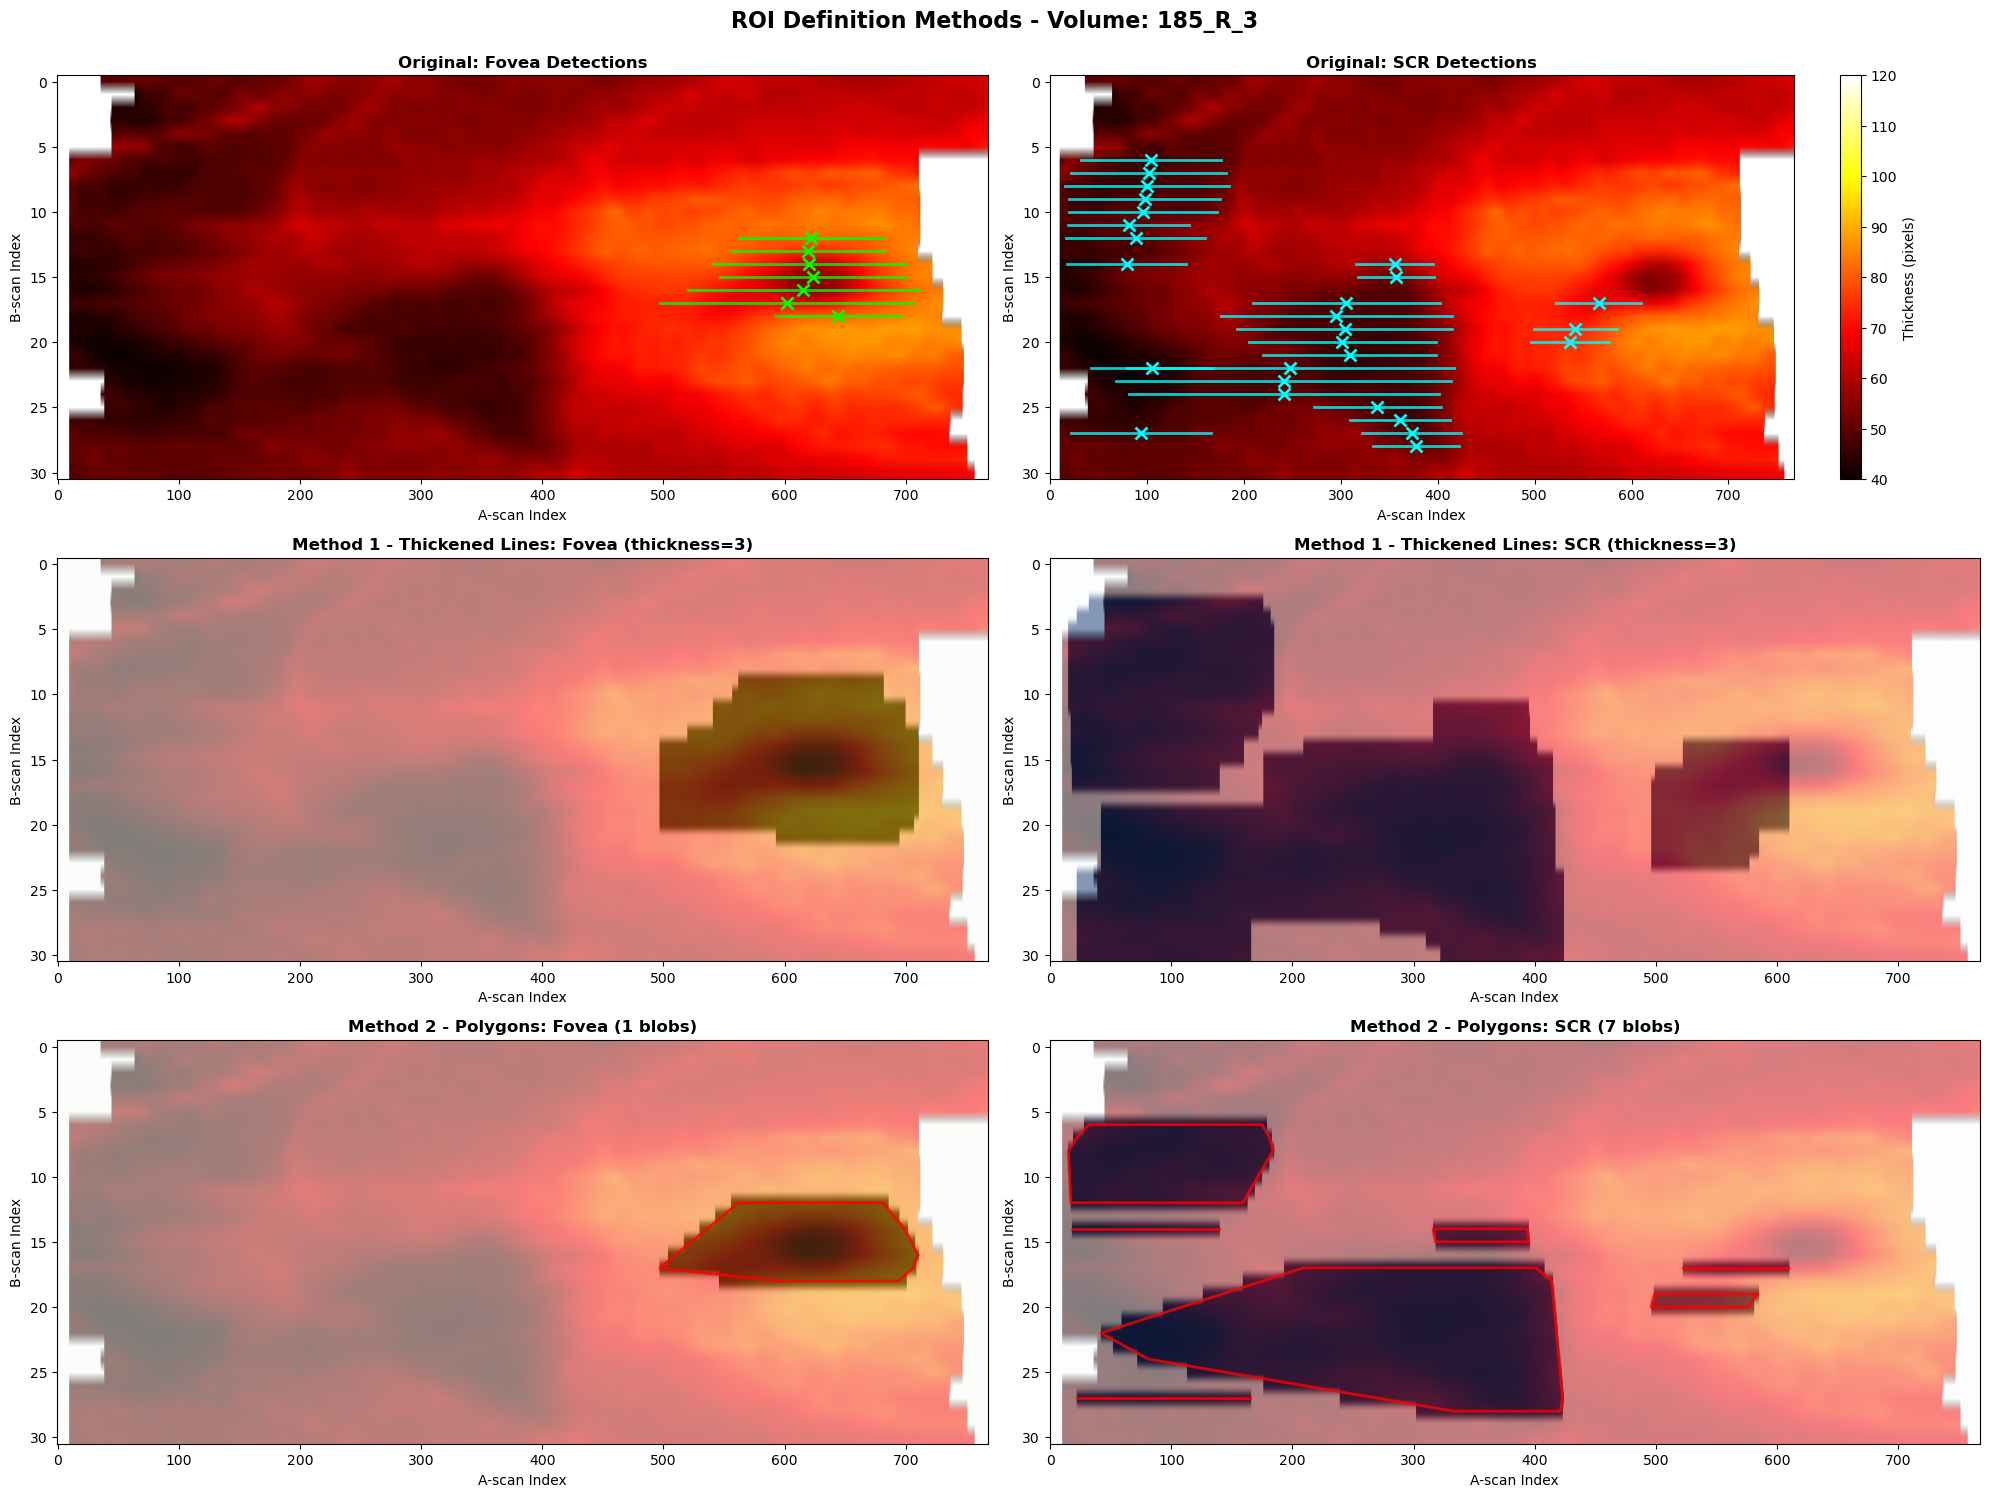


ROI STATISTICS - Volume: 185_R_3
Thickness map shape: (31, 768)
Score threshold: 0.7
Line thickness: 3 pixels (total width: 7)

Method 1 - Thickened Lines Coverage:
  Fovea: 9.87% (2350 pixels)
  SCR:   37.84% (9010 pixels)

Method 2 - Polygon Coverage:
  Fovea: 5.12% (1219 pixels, 1 blobs)
  SCR:   21.81% (5192 pixels, 7 blobs)

Detections (score >= 0.7):
  Fovea: 7
  SCR:   27


In [17]:
# Test ROI methods on a volume
if sorted_volumes:
    test_volume = sorted_volumes[0][0]
    print(f"Testing ROI methods on volume: {test_volume}\n")
    
    results = plot_roi_methods(
        volume_id='185_R_3',
        score_threshold=0.7,
        line_thickness=3
    )

In [ ]:
def save_roi_masks(volume_id, results, output_dir='roi_masks'):
    """
    Save ROI masks to compressed .npz file.
    
    Parameters:
    -----------
    volume_id : str
        Volume identifier
    results : dict
        Dictionary returned by plot_roi_methods()
    output_dir : str
        Directory to save masks
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    output_path = os.path.join(output_dir, f'{volume_id}_roi.npz')
    
    np.savez_compressed(
        output_path,
        volume_id=volume_id,
        thickness_map=results['thickness_map'],
        roi_fovea_lines=results['roi_fovea_lines'],
        roi_scr_lines=results['roi_scr_lines'],
        roi_fovea_poly=results['roi_fovea_poly'],
        roi_scr_poly=results['roi_scr_poly']
    )
    
    print(f"ROI masks saved to: {output_path}")

# Example usage:
# save_roi_masks(test_volume, results)

Testing ROI methods on volume: 142_R_3



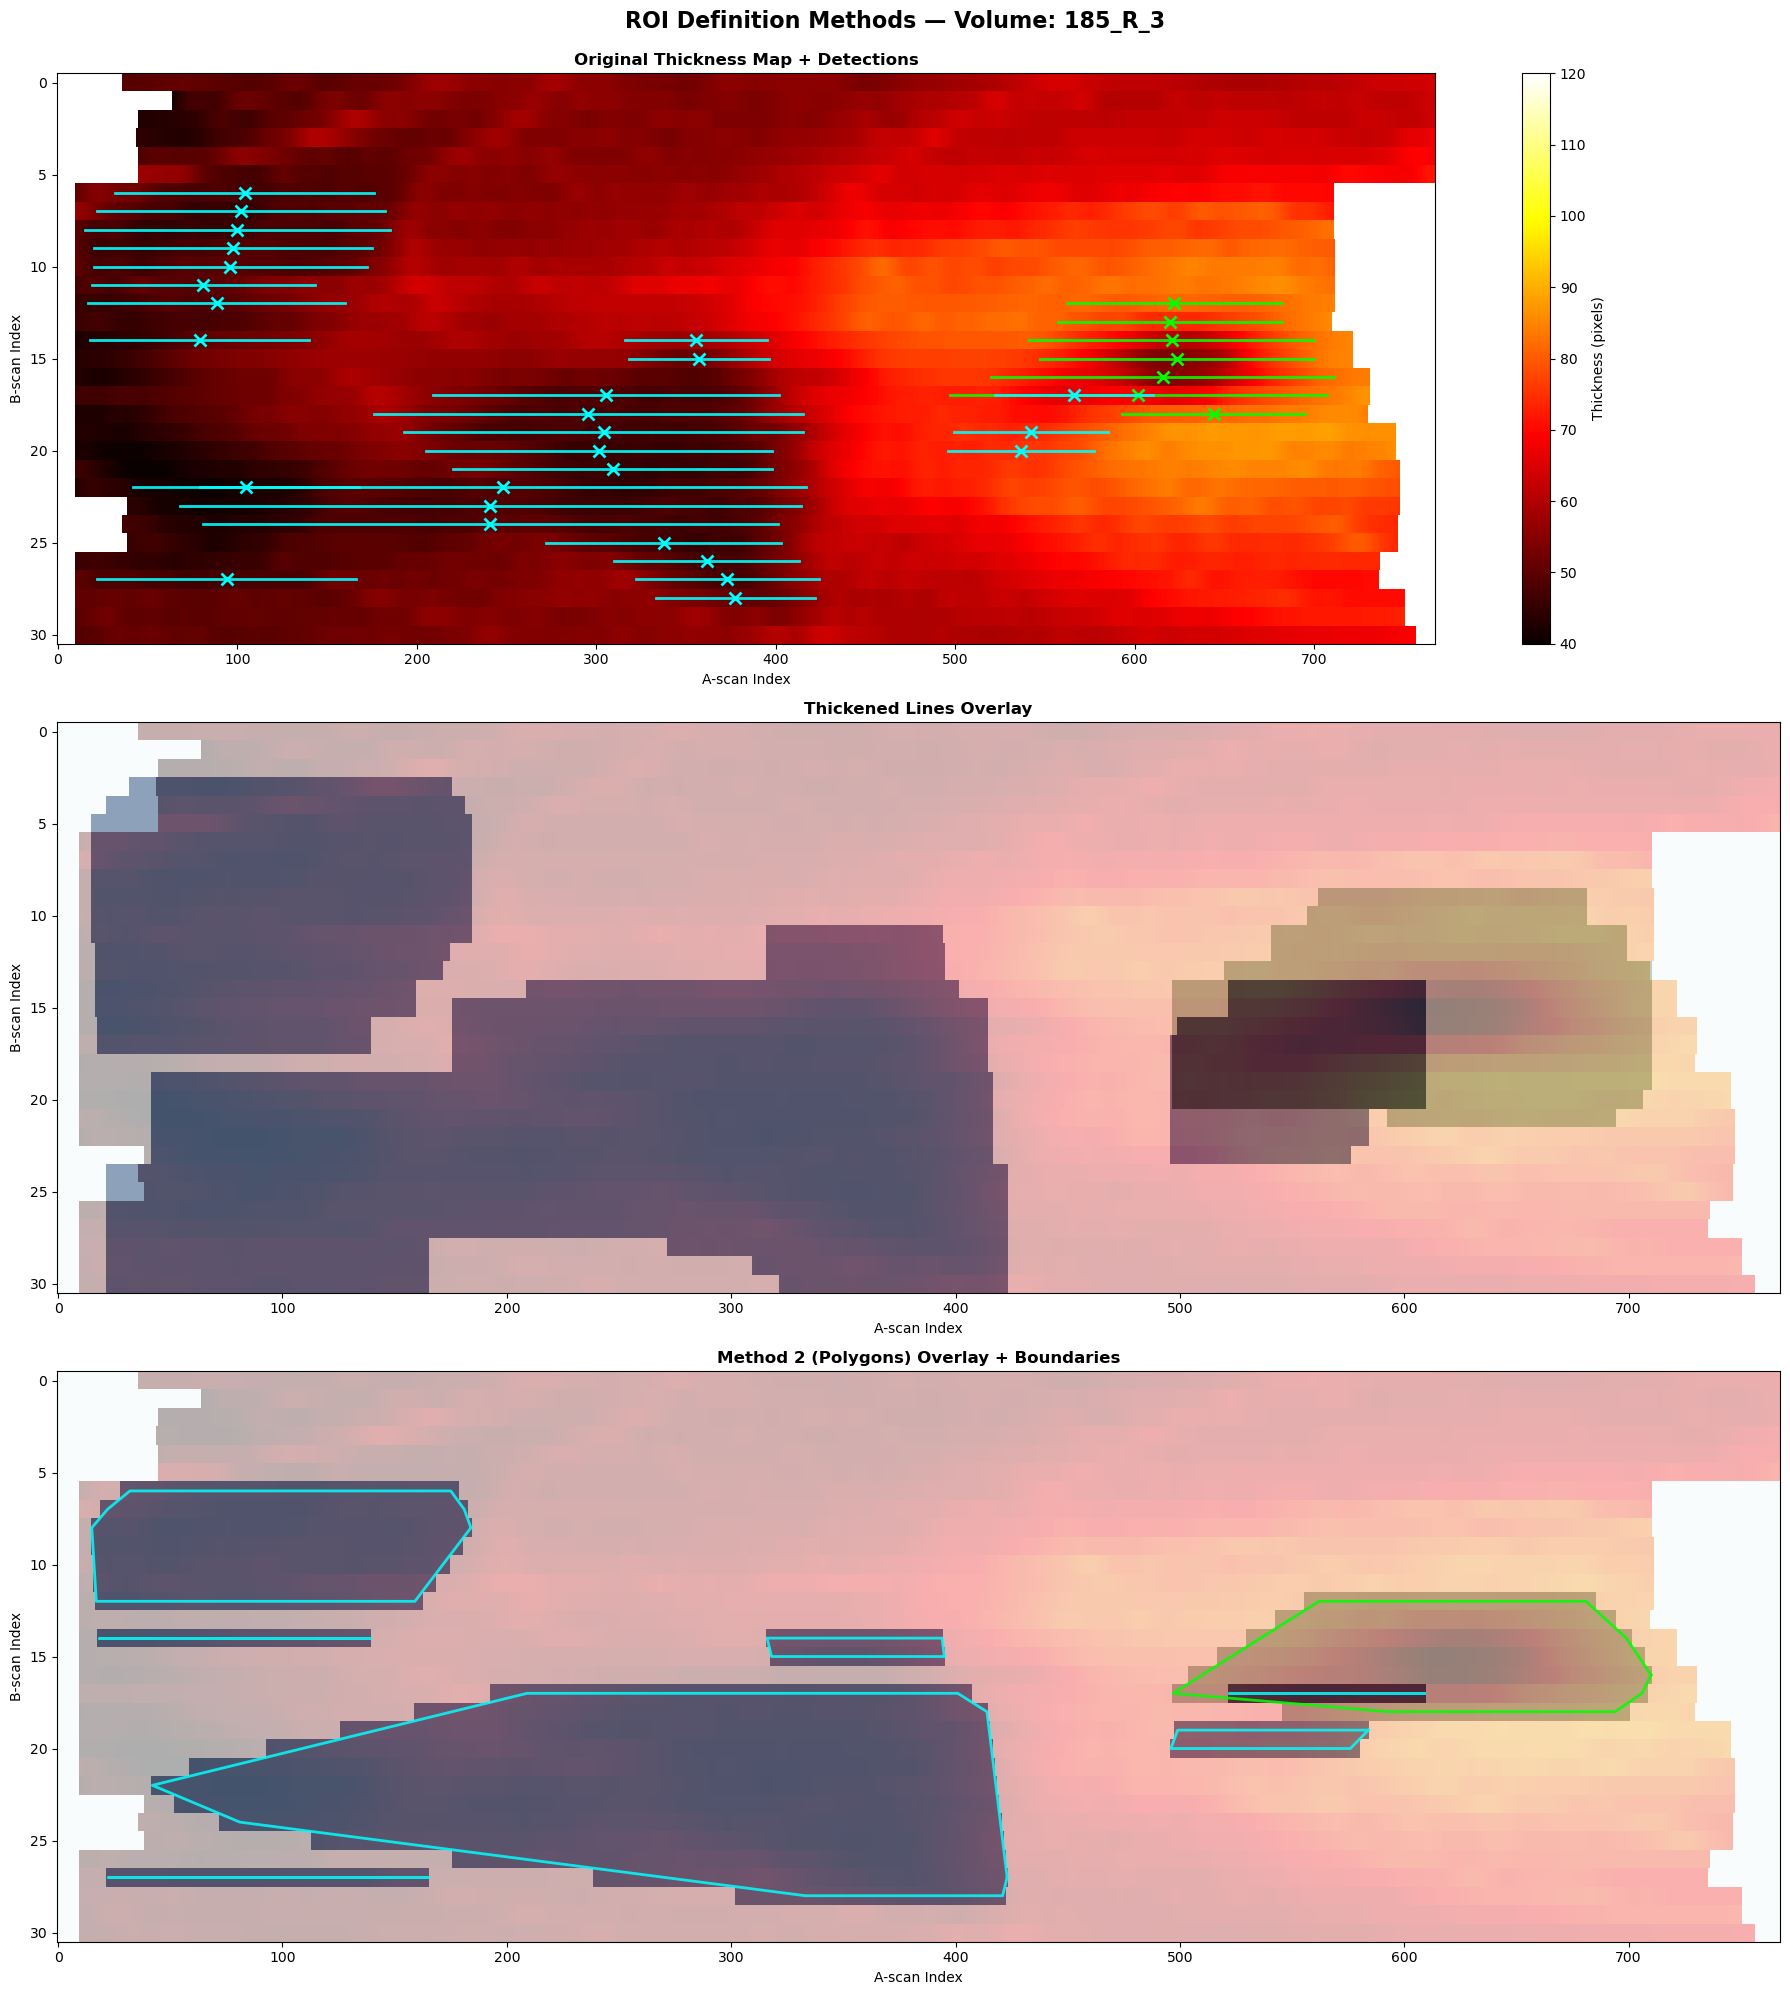


ROI STATISTICS — Volume: 185_R_3
Thickness map shape: (31, 768)
Score threshold: 0.7
Line thickness: 3 px (total width: 7)

Method 1 (Thickened Lines) Coverage:
  Fovea: 9.87% (2350 px)
  SCR:   37.84% (9010 px)
  Union: 44.61% (10621 px)

Method 2 (Polygons) Coverage:
  Fovea: 5.12% (1219 px, 1 blobs)
  SCR:   21.81% (5192 px, 7 blobs)
  Union: 26.56% (6323 px)

Detections (score >= 0.7):
  Fovea: 7
  SCR:   27


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_roi_methods(
    volume_id,
    score_threshold=0.7,
    line_thickness=3,
    figsize=(18, 20),
    thickness_vmin=40,
    thickness_vmax=120,
    cmap_thickness="hot",
    fovea_color="lime",
    scr_color="cyan",
    fovea_mask_cmap="Greens",
    scr_mask_cmap="Blues",
):
    """
    Visualize ROI methods with:
      - NO blur on thickness map (no interpolation smoothing)
      - ONE plot per row (fovea + SCR overlaid in the same axes)

    Layout (3 rows, 1 column):
      Row 1: Original thickness map + detections (fovea+SCR)
      Row 2: Method 1 thickened-line ROI overlay (fovea+SCR)
      Row 3: Method 2 polygon ROI overlay + polygon boundaries (fovea+SCR)
    """
    # Create thickness map
    thickness_map, bb_info, bscan_indices = create_volume_thickness_map(volume_id, score_threshold)
    if thickness_map is None:
        return None

    # -----------------------------
    # ROI masks (two methods)
    # -----------------------------
    # Method 1: Thickened lines
    roi_fovea_lines = create_thickened_line_roi(
        thickness_map, bb_info, line_thickness, label_filter=1
    )
    roi_scr_lines = create_thickened_line_roi(
        thickness_map, bb_info, line_thickness, label_filter=2
    )

    # Method 2: Polygons
    roi_fovea_poly, polygons_fovea = create_polygon_roi(
        thickness_map, bb_info, label_filter=1
    )
    roi_scr_poly, polygons_scr = create_polygon_roi(
        thickness_map, bb_info, label_filter=2
    )

    # -----------------------------
    # Plot helpers
    # -----------------------------
    def _imshow_thickness(ax):
        # IMPORTANT: no blur -> interpolation='nearest'
        im = ax.imshow(
            thickness_map,
            aspect="auto",
            cmap=cmap_thickness,
            interpolation="nearest",
            vmin=thickness_vmin,
            vmax=thickness_vmax,
        )
        ax.set_xlabel("A-scan Index")
        ax.set_ylabel("B-scan Index")
        return im

    def _overlay_detections(ax):
        # Draw both classes on the same axes
        for idx, bb_data in enumerate(bb_info):
            for box in bb_data["boxes"]:
                if box["label"] == 1:
                    color = fovea_color
                elif box["label"] == 2:
                    color = scr_color
                else:
                    continue

                ax.plot([box["x1"], box["x2"]], [idx, idx], color=color, linewidth=2, alpha=0.9)
                center_x = (box["x1"] + box["x2"]) / 2.0
                ax.plot(center_x, idx, "x", color=color, markersize=8, markeredgewidth=2)

    def _overlay_masks(ax, fovea_mask, scr_mask, alpha=0.45):
        # Overlay fovea and SCR masks separately (different colormaps) on the same axes
        ax.imshow(fovea_mask.astype(np.float32), aspect="auto", cmap=fovea_mask_cmap,
                  interpolation="nearest", alpha=alpha, vmin=0, vmax=1)
        ax.imshow(scr_mask.astype(np.float32), aspect="auto", cmap=scr_mask_cmap,
                  interpolation="nearest", alpha=alpha, vmin=0, vmax=1)

    def _draw_polygons(ax, polygons, edge_color):
        for poly_points in polygons:
            if poly_points is None or len(poly_points) == 0:
                continue
            poly_points = np.asarray(poly_points)
            poly_closed = np.vstack([poly_points, poly_points[0]])
            ax.plot(poly_closed[:, 0], poly_closed[:, 1], "-", color=edge_color, linewidth=2, alpha=0.85)

    # -----------------------------
    # Figure: 3x1
    # -----------------------------
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=False, sharey=False)

    # Row 1: Original + detections
    im = _imshow_thickness(axes[0])
    _overlay_detections(axes[0])
    axes[0].set_title("Original Thickness Map + Detections", fontweight="bold", fontsize=12)
    plt.colorbar(im, ax=axes[0], label="Thickness (pixels)")

    # Row 2: Method 1 overlay (thickened lines mask)
    _imshow_thickness(axes[1])
    _overlay_masks(axes[1], roi_fovea_lines, roi_scr_lines, alpha=0.45)
    axes[1].set_title(
        f"Thickened Lines Overlay",
        fontweight="bold",
        fontsize=12,
    )

    # Row 3: Method 2 overlay (polygon mask) + polygon boundaries
    _imshow_thickness(axes[2])
    _overlay_masks(axes[2], roi_fovea_poly, roi_scr_poly, alpha=0.45)
    _draw_polygons(axes[2], polygons_fovea, edge_color=fovea_color)
    _draw_polygons(axes[2], polygons_scr, edge_color=scr_color)
    axes[2].set_title(
        f"Method 2 (Polygons) Overlay + Boundaries",
        fontweight="bold",
        fontsize=12,
    )

    plt.suptitle(f"ROI Definition Methods — Volume: {volume_id}", fontsize=16, fontweight="bold", y=0.995)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Statistics
    # -----------------------------
    print(f"\n{'='*80}")
    print(f"ROI STATISTICS — Volume: {volume_id}")
    print(f"{'='*80}")
    print(f"Thickness map shape: {thickness_map.shape}")
    print(f"Score threshold: {score_threshold}")
    print(f"Line thickness: {line_thickness} px (total width: {2*line_thickness+1})")

    total_pixels = thickness_map.size

    # Coverage per class per method
    print(f"\nMethod 1 (Thickened Lines) Coverage:")
    print(f"  Fovea: {100 * roi_fovea_lines.sum() / total_pixels:.2f}% ({int(roi_fovea_lines.sum())} px)")
    print(f"  SCR:   {100 * roi_scr_lines.sum() / total_pixels:.2f}% ({int(roi_scr_lines.sum())} px)")
    print(f"  Union: {100 * np.logical_or(roi_fovea_lines, roi_scr_lines).sum() / total_pixels:.2f}% "
          f"({int(np.logical_or(roi_fovea_lines, roi_scr_lines).sum())} px)")

    print(f"\nMethod 2 (Polygons) Coverage:")
    print(f"  Fovea: {100 * roi_fovea_poly.sum() / total_pixels:.2f}% ({int(roi_fovea_poly.sum())} px, {len(polygons_fovea)} blobs)")
    print(f"  SCR:   {100 * roi_scr_poly.sum() / total_pixels:.2f}% ({int(roi_scr_poly.sum())} px, {len(polygons_scr)} blobs)")
    print(f"  Union: {100 * np.logical_or(roi_fovea_poly, roi_scr_poly).sum() / total_pixels:.2f}% "
          f"({int(np.logical_or(roi_fovea_poly, roi_scr_poly).sum())} px)")

    # Count detections
    n_fovea = sum(sum(1 for box in bb["boxes"] if box["label"] == 1) for bb in bb_info)
    n_scr = sum(sum(1 for box in bb["boxes"] if box["label"] == 2) for bb in bb_info)
    print(f"\nDetections (score >= {score_threshold}):")
    print(f"  Fovea: {n_fovea}")
    print(f"  SCR:   {n_scr}")

    return {
        "thickness_map": thickness_map,
        "bb_info": bb_info,
        "roi_fovea_lines": roi_fovea_lines,
        "roi_scr_lines": roi_scr_lines,
        "roi_fovea_poly": roi_fovea_poly,
        "roi_scr_poly": roi_scr_poly,
        "polygons_fovea": polygons_fovea,
        "polygons_scr": polygons_scr,
    }


# -----------------------------
# Usage
# -----------------------------
if sorted_volumes:
    test_volume = sorted_volumes[0][0]
    print(f"Testing ROI methods on volume: {test_volume}\n")

    results = plot_roi_methods(
        volume_id="185_R_3",
        score_threshold=0.7,
        line_thickness=3,
    )


Testing ROI methods on volume: 142_R_3



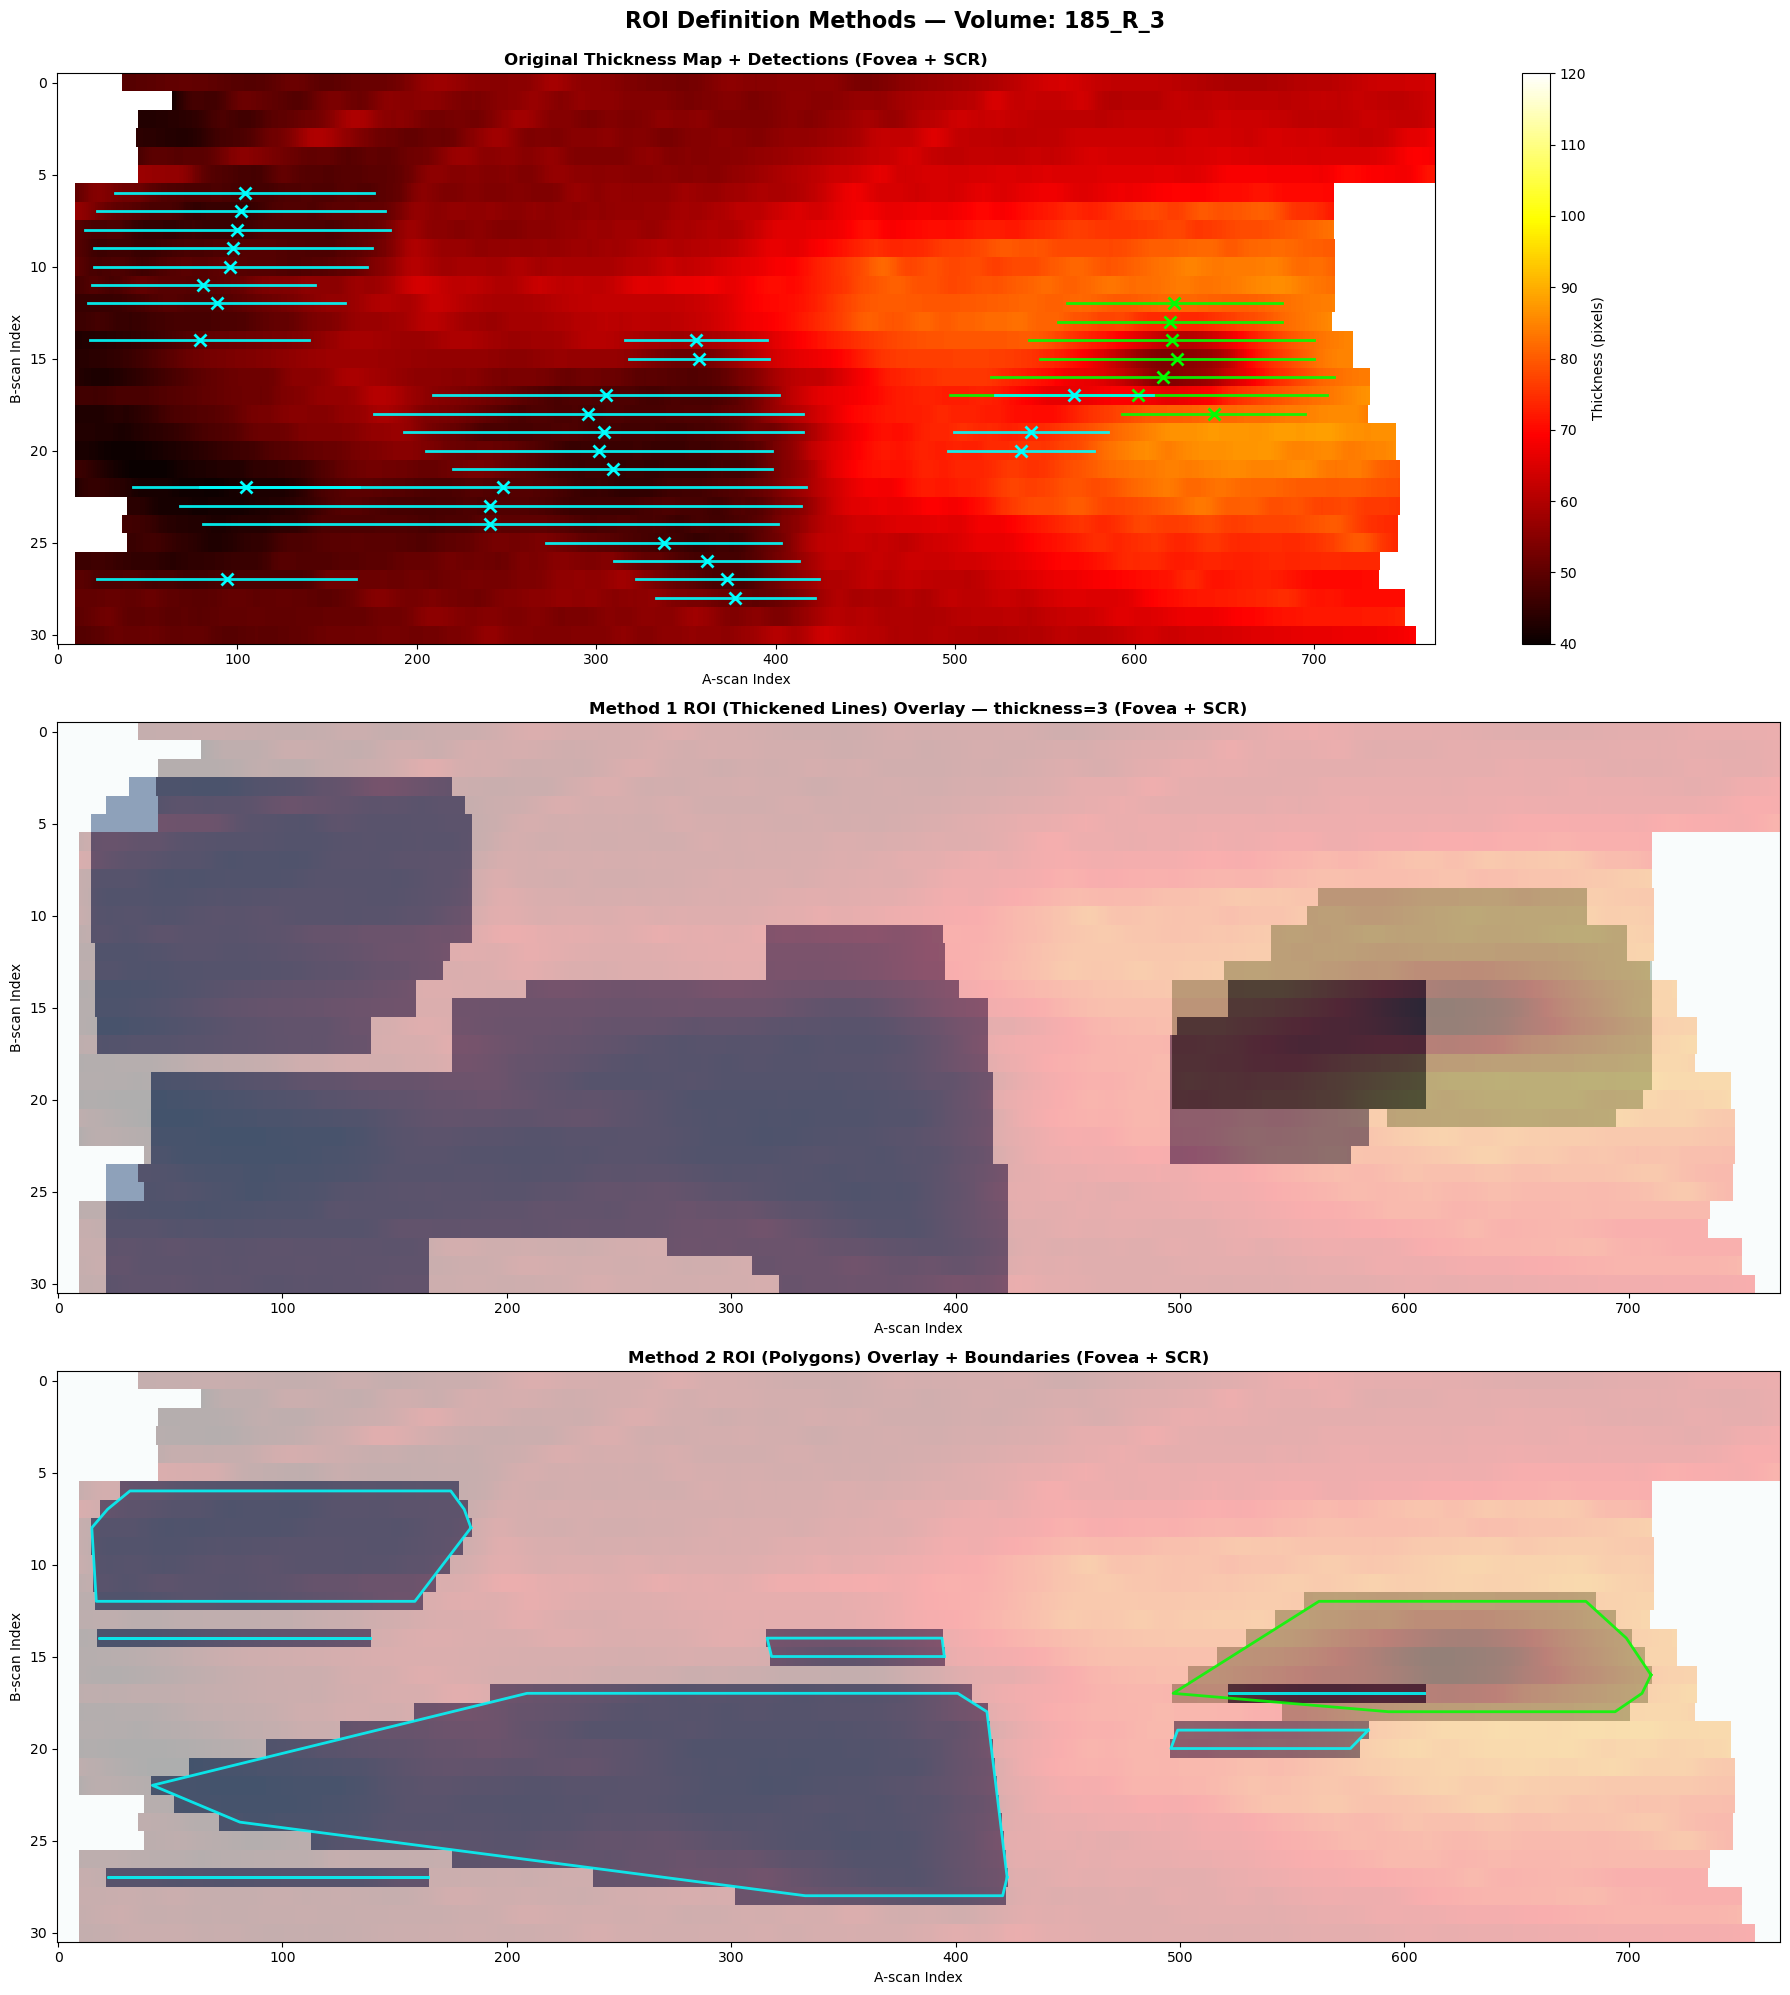


ROI STATISTICS — Volume: 185_R_3
Thickness map shape: (31, 768)
Score threshold: 0.7
Line thickness: 3 px (total width: 7)

Method 1 (Thickened Lines) Coverage:
  Fovea: 9.87% (2350 px)
  SCR:   37.84% (9010 px)
  Union: 44.61% (10621 px)

Method 2 (Polygons) Coverage:
  Fovea: 5.12% (1219 px, 1 blobs)
  SCR:   21.81% (5192 px, 7 blobs)
  Union: 26.56% (6323 px)

Detections (score >= 0.7):
  Fovea: 7
  SCR:   27


Testing ROI methods on volume: 142_R_3



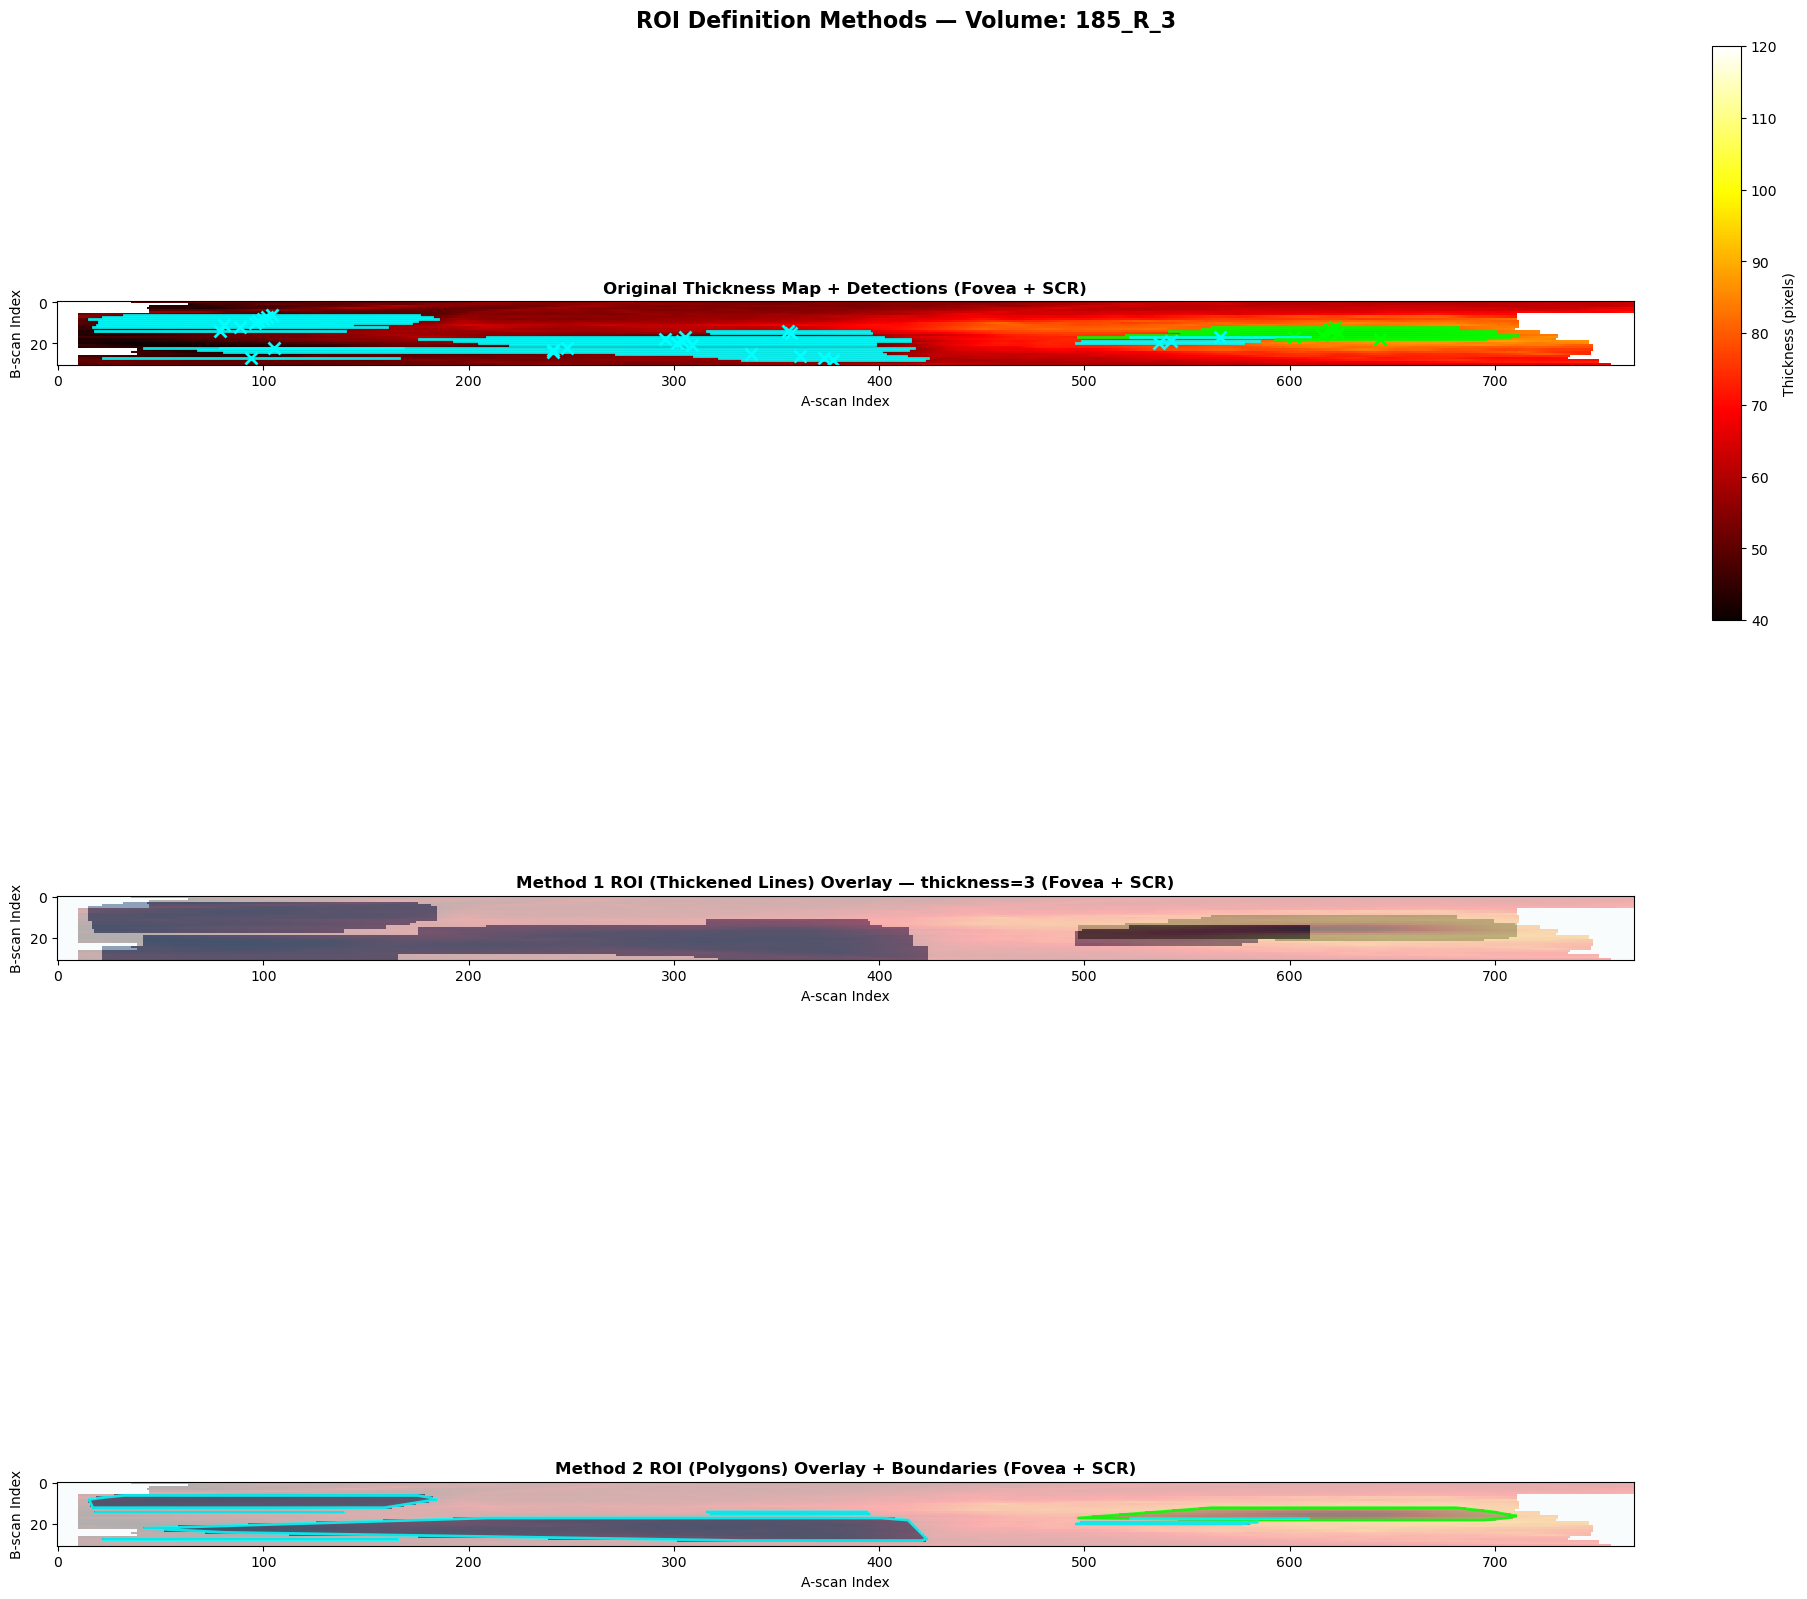


ROI STATISTICS — Volume: 185_R_3
Thickness map shape: (31, 768)
Score threshold: 0.7
Line thickness: 3 px (total width: 7)

Method 1 (Thickened Lines) Coverage:
  Fovea: 9.87% (2350 px)
  SCR:   37.84% (9010 px)
  Union: 44.61% (10621 px)

Method 2 (Polygons) Coverage:
  Fovea: 5.12% (1219 px, 1 blobs)
  SCR:   21.81% (5192 px, 7 blobs)
  Union: 26.56% (6323 px)

Detections (score >= 0.7):
  Fovea: 7
  SCR:   27


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_roi_methods(
    volume_id,
    score_threshold=0.7,
    line_thickness=3,
    figsize=(18, 18),
    thickness_vmin=40,
    thickness_vmax=120,
    cmap_thickness="hot",
    fovea_color="lime",
    scr_color="cyan",
    fovea_mask_cmap="Greens",
    scr_mask_cmap="Blues",
):
    """
    3 square panels (3 rows x 1 col). Each panel is forced to render as a square
    regardless of the underlying thickness_map shape, without resampling the data.

    - No blur: interpolation='nearest'
    - One plot per row: fovea + SCR overlaid together
    - Square display: aspect=1 (equal scaling in x/y)
    """
    thickness_map, bb_info, bscan_indices = create_volume_thickness_map(volume_id, score_threshold)
    if thickness_map is None:
        return None

    # Method 1: Thickened lines
    roi_fovea_lines = create_thickened_line_roi(thickness_map, bb_info, line_thickness, label_filter=1)
    roi_scr_lines   = create_thickened_line_roi(thickness_map, bb_info, line_thickness, label_filter=2)

    # Method 2: Polygons
    roi_fovea_poly, polygons_fovea = create_polygon_roi(thickness_map, bb_info, label_filter=1)
    roi_scr_poly,   polygons_scr   = create_polygon_roi(thickness_map, bb_info, label_filter=2)

    def _imshow_thickness(ax):
        # Force square *rendering* (not data resizing)
        im = ax.imshow(
            thickness_map,
            cmap=cmap_thickness,
            interpolation="nearest",   # no blur
            vmin=thickness_vmin,
            vmax=thickness_vmax,
            aspect=1,                  # square pixels (equal x/y scaling)
        )
        ax.set_xlabel("A-scan Index")
        ax.set_ylabel("B-scan Index")
        return im

    def _overlay_detections(ax):
        for idx, bb_data in enumerate(bb_info):
            for box in bb_data["boxes"]:
                if box["label"] == 1:
                    color = fovea_color
                elif box["label"] == 2:
                    color = scr_color
                else:
                    continue

                ax.plot([box["x1"], box["x2"]], [idx, idx], color=color, linewidth=2, alpha=0.9)
                cx = (box["x1"] + box["x2"]) / 2.0
                ax.plot(cx, idx, "x", color=color, markersize=8, markeredgewidth=2)

    def _overlay_masks(ax, fovea_mask, scr_mask, alpha=0.45):
        ax.imshow(
            fovea_mask.astype(np.float32),
            cmap=fovea_mask_cmap,
            interpolation="nearest",
            alpha=alpha,
            vmin=0, vmax=1,
            aspect=1,
        )
        ax.imshow(
            scr_mask.astype(np.float32),
            cmap=scr_mask_cmap,
            interpolation="nearest",
            alpha=alpha,
            vmin=0, vmax=1,
            aspect=1,
        )

    def _draw_polygons(ax, polygons, edge_color):
        for poly in polygons:
            if poly is None or len(poly) == 0:
                continue
            poly = np.asarray(poly)
            poly_closed = np.vstack([poly, poly[0]])
            ax.plot(poly_closed[:, 0], poly_closed[:, 1], "-", color=edge_color, linewidth=2, alpha=0.85)

    # 3 square panels: best effort via figsize + aspect=1
    fig, axes = plt.subplots(3, 1, figsize=figsize, constrained_layout=True)

    im = _imshow_thickness(axes[0])
    _overlay_detections(axes[0])
    axes[0].set_title("Original Thickness Map + Detections (Fovea + SCR)", fontweight="bold", fontsize=12)
    plt.colorbar(im, ax=axes[0], label="Thickness (pixels)")

    _imshow_thickness(axes[1])
    _overlay_masks(axes[1], roi_fovea_lines, roi_scr_lines, alpha=0.45)
    axes[1].set_title(
        f"Method 1 ROI (Thickened Lines) Overlay — thickness={line_thickness} (Fovea + SCR)",
        fontweight="bold",
        fontsize=12,
    )

    _imshow_thickness(axes[2])
    _overlay_masks(axes[2], roi_fovea_poly, roi_scr_poly, alpha=0.45)
    _draw_polygons(axes[2], polygons_fovea, edge_color=fovea_color)
    _draw_polygons(axes[2], polygons_scr, edge_color=scr_color)
    axes[2].set_title("Method 2 ROI (Polygons) Overlay + Boundaries (Fovea + SCR)", fontweight="bold", fontsize=12)

    fig.suptitle(f"ROI Definition Methods — Volume: {volume_id}", fontsize=16, fontweight="bold")
    plt.show()

    # Stats (unchanged)
    print(f"\n{'='*80}")
    print(f"ROI STATISTICS — Volume: {volume_id}")
    print(f"{'='*80}")
    print(f"Thickness map shape: {thickness_map.shape}")
    print(f"Score threshold: {score_threshold}")
    print(f"Line thickness: {line_thickness} px (total width: {2*line_thickness+1})")

    total_pixels = thickness_map.size

    print(f"\nMethod 1 (Thickened Lines) Coverage:")
    print(f"  Fovea: {100 * roi_fovea_lines.sum() / total_pixels:.2f}% ({int(roi_fovea_lines.sum())} px)")
    print(f"  SCR:   {100 * roi_scr_lines.sum() / total_pixels:.2f}% ({int(roi_scr_lines.sum())} px)")
    print(f"  Union: {100 * np.logical_or(roi_fovea_lines, roi_scr_lines).sum() / total_pixels:.2f}% "
          f"({int(np.logical_or(roi_fovea_lines, roi_scr_lines).sum())} px)")

    print(f"\nMethod 2 (Polygons) Coverage:")
    print(f"  Fovea: {100 * roi_fovea_poly.sum() / total_pixels:.2f}% ({int(roi_fovea_poly.sum())} px, {len(polygons_fovea)} blobs)")
    print(f"  SCR:   {100 * roi_scr_poly.sum() / total_pixels:.2f}% ({int(roi_scr_poly.sum())} px, {len(polygons_scr)} blobs)")
    print(f"  Union: {100 * np.logical_or(roi_fovea_poly, roi_scr_poly).sum() / total_pixels:.2f}% "
          f"({int(np.logical_or(roi_fovea_poly, roi_scr_poly).sum())} px)")

    n_fovea = sum(sum(1 for box in bb["boxes"] if box["label"] == 1) for bb in bb_info)
    n_scr   = sum(sum(1 for box in bb["boxes"] if box["label"] == 2) for bb in bb_info)
    print(f"\nDetections (score >= {score_threshold}):")
    print(f"  Fovea: {n_fovea}")
    print(f"  SCR:   {n_scr}")

    return {
        "thickness_map": thickness_map,
        "bb_info": bb_info,
        "roi_fovea_lines": roi_fovea_lines,
        "roi_scr_lines": roi_scr_lines,
        "roi_fovea_poly": roi_fovea_poly,
        "roi_scr_poly": roi_scr_poly,
        "polygons_fovea": polygons_fovea,
        "polygons_scr": polygons_scr,
    }


# Usage
if sorted_volumes:
    test_volume = sorted_volumes[0][0]
    print(f"Testing ROI methods on volume: {test_volume}\n")
    results = plot_roi_methods(volume_id="185_R_3", score_threshold=0.7, line_thickness=3)
